# Grey radiation modeling with climlab

This notebook is part of [The Climate Laboratory](https://brian-rose.github.io/ClimateLaboratoryBook) by [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany.

____________
<a id='section1'></a>

## 1. Introducing `climlab`
____________

``climlab`` is a flexible engine for process-oriented climate modeling.
It is based on a very general concept of a model as a collection of individual, 
interacting processes. ``climlab`` defines a base class called ``Process``, which
can contain an arbitrarily complex tree of sub-processes (each also some 
sub-class of ``Process``). Every climate process (radiative, dynamical, 
physical, turbulent, convective, chemical, etc.) can be simulated as a stand-alone
process model given appropriate input, or as a sub-process of a more complex model. 
New classes of model can easily be defined and run interactively by putting together an
appropriate collection of sub-processes.

``climlab`` is a work-in-progress, and the code base will evolve substantially over the course of this semester.
The latest code can always be found on ``github``:

https://github.com/brian-rose/climlab

You are strongly encouraged to clone the ``climlab`` repository and use ``git`` to keep your local copy up-to-date.

Running this notebook requires that ``climlab`` is already installed on your system.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from numpy import cos, deg2rad, log
import climlab

____________
<a id='section2'></a>

## 2. Using `climlab` to implement the two-layer leaky greenhouse model
____________

One of the things that ``climlab`` is set up to do is the grey-radiation modeling we have already been discussing.

Since we already derived a [complete analytical solution to the two-layer leaky greenhouse model](Lecture06 -- Elementary greenhouse models.ipynb), we will use this to validate the `climlab` code.



### Validation

We want to verify that the model reproduces the observed OLR given observed temperatures, and the absorptivity that we tuned in the analytical model. The target numbers are:

\begin{align}
T_s &= 288 \text{ K} \\
T_0 &= 275 \text{ K} \\
T_1 &= 230 \text{ K} \\
\end{align}

$$ \epsilon = 0.586  $$

$$ OLR = 238.5 \text{ W m}^{-2} $$


### Initialize a model in `climlab`
The first thing we do is create a new model.

The following example code is sparsely commented but will hopefully orient you on the basics of defining and working with a `climlab Process` object.

In [2]:
#  Test in a 2-layer atmosphere
col = climlab.GreyRadiationModel(num_lev=2)
print( col)

climlab Process of type <class 'climlab.model.column.GreyRadiationModel'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (2,) 
The subprocess tree: 
Untitled: <class 'climlab.model.column.GreyRadiationModel'>
   LW: <class 'climlab.radiation.greygas.GreyGas'>
   SW: <class 'climlab.radiation.greygas.GreyGasSW'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>



In [3]:
col.subprocess

AttrDict({'LW': <climlab.radiation.greygas.GreyGas object at 0x7fed897879a0>, 'SW': <climlab.radiation.greygas.GreyGasSW object at 0x7fed8ecee640>, 'insolation': <climlab.radiation.insolation.FixedInsolation object at 0x7fed8ecee970>})

Every item in the above dictionary is itself an instance of the `climlab.Process` object:

In [4]:
print( col.subprocess['LW'])

climlab Process of type <class 'climlab.radiation.greygas.GreyGas'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (2,) 
The subprocess tree: 
Untitled: <class 'climlab.radiation.greygas.GreyGas'>



The `state` dictionary holds the state variables of the model. In this case, temperatures:

In [5]:
climlab.to_xarray(col.state)

<xarray.Dataset>
Dimensions:       (depth: 1, depth_bounds: 2, lev: 2, lev_bounds: 3)
Coordinates:
  * depth         (depth) float64 0.5
  * depth_bounds  (depth_bounds) float64 0.0 1.0
  * lev           (lev) float64 250.0 750.0
  * lev_bounds    (lev_bounds) float64 0.0 500.0 1e+03
Data variables:
    Ts            (depth) float64 288.0
    Tatm          (lev) float64 200.0 278.0

Access these either through dictionary methods or as attributes of the model object:

In [6]:
print( col.state['Ts'])
print( col.Ts)
col.Ts is col.state['Ts']

[288.]
[288.]


True

Now we are assigning the "observed" temperatures to our model state:

In [7]:
col.Ts[:] = 288.
col.Tatm[:] = np.array([230., 275.])
climlab.to_xarray(col.state)

<xarray.Dataset>
Dimensions:       (depth: 1, depth_bounds: 2, lev: 2, lev_bounds: 3)
Coordinates:
  * depth         (depth) float64 0.5
  * depth_bounds  (depth_bounds) float64 0.0 1.0
  * lev           (lev) float64 250.0 750.0
  * lev_bounds    (lev_bounds) float64 0.0 500.0 1e+03
Data variables:
    Ts            (depth) float64 288.0
    Tatm          (lev) float64 230.0 275.0

In [8]:
LW = col.subprocess['LW']
print(LW)

climlab Process of type <class 'climlab.radiation.greygas.GreyGas'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (2,) 
The subprocess tree: 
Untitled: <class 'climlab.radiation.greygas.GreyGas'>



In [9]:
LW.absorptivity

Field([0.47737425, 0.47737425])

In [10]:
#  copying the tuned value of epsilon from Lecture 6 notes
LW.absorptivity = 0.586
LW.absorptivity

Field([0.586, 0.586])

In [11]:
#  This does all the calculations that would be performed at each time step, 
#  but doesn't actually update the temperatures
col.compute_diagnostics()
#  Print out the dictionary
col.diagnostics

{'flux_from_sfc': Field([102.0487]),
 'flux_to_sfc': array([341.3]),
 'flux_to_space': array([102.0487]),
 'absorbed': array([0., 0.]),
 'absorbed_total': 0.0,
 'emission': Field([0., 0.]),
 'emission_sfc': Field([0.]),
 'flux_reflected_up': array([  0.    ,   0.    , 102.0487]),
 'insolation': Field([341.3]),
 'coszen': Field([1.]),
 'OLR': array([238.5247311]),
 'LW_down_sfc': array([228.53426769]),
 'LW_up_sfc': Field([390.10502995]),
 'LW_absorbed_sfc': Field([-161.57076227]),
 'LW_absorbed_atm': array([ 20.02990881, -96.98387764]),
 'LW_emission': Field([ 92.98664086, 190.03779837]),
 'ASR': Field([239.2513]),
 'SW_absorbed_sfc': Field([239.2513]),
 'SW_absorbed_atm': array([0., 0.]),
 'SW_up_sfc': Field([102.0487]),
 'SW_up_TOA': array([102.0487]),
 'SW_down_TOA': Field([341.3]),
 'planetary_albedo': Field([0.299])}

In [12]:
#  Check OLR against our analytical solution
col.OLR

array([238.5247311])

In [13]:
# Like the state variables, the diagnostics can also be accessed in two different ways
col.diagnostics['OLR']

array([238.5247311])

In [14]:
col.state

AttrDict({'Ts': Field([288.]), 'Tatm': Field([230., 275.])})

In [15]:
# perform a single time step
col.step_forward()

In [16]:
col.state

AttrDict({'Ts': Field([289.60514636]), 'Tatm': Field([230.33784312, 273.3641795 ])})

We just stepped forward one discreet unit in time. Because we didn't specify a timestep when we created the model, it is set to a default value:

In [17]:
col.timestep

86400.0

which is 1 day (expressed in seconds).

Now we will integrate the model out to equilibrium.

We could easily write a loop to call the `step_forward()` method many times.

Or use a handy shortcut that allows us to specify the integration length in physical time units:

In [18]:
# integrate out to radiative equilibrium
col.integrate_years(2.)

Integrating for 730 steps, 730.4844 days, or 2.0 years.


Total elapsed time is 2.0014116660123062 years.


In [19]:
# Check for equilibrium
col.ASR - col.OLR

Field([-2.34514516e-07])

In [20]:
#  The temperatures at radiative equilibrium
col.state

AttrDict({'Ts': Field([296.38447748]), 'Tatm': Field([233.72131685, 262.28540231])})

Compare these to the analytical solutions for radiative equilibrium with $\epsilon = 0.58$:

\begin{align}
T_s &= 296.4 \text{ K} \\
T_0 &= 262.3 \text{ K} \\
T_1 &= 233.8 \text{ K} \\
\end{align}


So it looks like `climlab` agrees with our analytical results to within 0.1 K. That's good.

____________
<a id='section3'></a>

## 3. The observed annual, global mean temperature profile
____________

We want to model the OLR in a column whose temperatures match observations. As we've done before, we'll calculate the global, annual mean air temperature from the NCEP Reanalysis data.

In [21]:
## The NOAA ESRL server is shutdown! January 2019
## This will try to read the data over the internet.
ncep_filename = 'air.mon.1981-2010.ltm.nc'
##  to read over internet
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/pressure/"
path = ncep_url
##  Open handle to data
ncep_air = xr.open_dataset( path + ncep_filename, decode_times=False )

#url = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/Reanalysis_Data/NCEP/NCEP/clima/pressure/air'
#air = xr.open_dataset(url)
# The name of the vertical axis is different than the NOAA ESRL version..
#ncep_air = air.rename({'lev': 'level'})
print( ncep_air)

<xarray.Dataset>
Dimensions:             (lat: 73, level: 17, lon: 144, nbnds: 2, time: 12)
Coordinates:
  * level               (level) float32 1e+03 925.0 850.0 ... 30.0 20.0 10.0
  * lon                 (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * time                (time) float64 -6.571e+05 -6.57e+05 ... -6.567e+05
  * lat                 (lat) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
Dimensions without coordinates: nbnds
Data variables:
    climatology_bounds  (time, nbnds) float64 ...
    air                 (time, level, lat, lon) float32 ...
    valid_yr_count      (time, level, lat, lon) float32 ...
Attributes:
    description:                     Data from NCEP initialized reanalysis (4...
    platform:                       Model
    Conventions:                    COARDS
    not_missing_threshold_percent:  minimum 3% values input to have non-missi...
    history:                        Created 2011/07/12 by doMonthLTM\nConvert...
    title:             

In [22]:
#  Take global, annual average and convert to Kelvin
weight = cos(deg2rad(ncep_air.lat)) / cos(deg2rad(ncep_air.lat)).mean(dim='lat')
Tglobal = (ncep_air.air * weight).mean(dim=('lat','lon','time'))
print( Tglobal)

<xarray.DataArray (level: 17)>
array([ 15.179084  ,  11.207003  ,   7.8383274 ,   0.21994135,
        -6.4483433 , -14.888848  , -25.570469  , -39.36969   ,
       -46.797905  , -53.652245  , -60.56356   , -67.006065  ,
       -65.53293   , -61.48664   , -55.853584  , -51.593952  ,
       -43.21999   ], dtype=float32)
Coordinates:
  * level    (level) float32 1e+03 925.0 850.0 700.0 ... 50.0 30.0 20.0 10.0


We're going to convert this to degrees Kelvin, using a handy list of pre-defined constants in `climlab.constants`

In [23]:
climlab.constants.tempCtoK

273.15

In [24]:
Tglobal += climlab.constants.tempCtoK
print(Tglobal)

<xarray.DataArray (level: 17)>
array([288.32907, 284.357  , 280.9883 , 273.36993, 266.70166, 258.26114,
       247.57953, 233.7803 , 226.35208, 219.49774, 212.58643, 206.14392,
       207.61707, 211.66336, 217.29642, 221.55605, 229.93001],
      dtype=float32)
Coordinates:
  * level    (level) float32 1e+03 925.0 850.0 700.0 ... 50.0 30.0 20.0 10.0


In [25]:
#  A handy re-usable routine for making a plot of the temperature profiles
#  We will plot temperatures with respect to log(pressure) to get a height-like coordinate

def zstar(lev):
    return -np.log(lev / climlab.constants.ps)

def plot_soundings(result_list, name_list, plot_obs=True, fixed_range=True):
    color_cycle=['r', 'g', 'b', 'y']
    # col is either a column model object or a list of column model objects
    #if isinstance(state_list, climlab.Process):
    #    # make a list with a single item
    #    collist = [collist]
    fig, ax = plt.subplots(figsize=(9,9))
    if plot_obs:
        ax.plot(Tglobal, zstar(Tglobal.level), color='k', label='Observed')    
    for i, state in enumerate(result_list):
        Tatm = state['Tatm']
        lev = Tatm.domain.axes['lev'].points
        Ts = state['Ts']
        ax.plot(Tatm, zstar(lev), color=color_cycle[i], label=name_list[i])
        ax.plot(Ts, 0, 'o', markersize=12, color=color_cycle[i])
    #ax.invert_yaxis()
    yticks = np.array([1000., 750., 500., 250., 100., 50., 20., 10., 5.])
    ax.set_yticks(-np.log(yticks/1000.))
    ax.set_yticklabels(yticks)
    ax.set_xlabel('Temperature (K)', fontsize=14)
    ax.set_ylabel('Pressure (hPa)', fontsize=14)
    ax.grid()
    ax.legend()
    if fixed_range:
        ax.set_xlim([200, 300])
        ax.set_ylim(zstar(np.array([1000., 5.])))
    #ax2 = ax.twinx()
    
    return ax

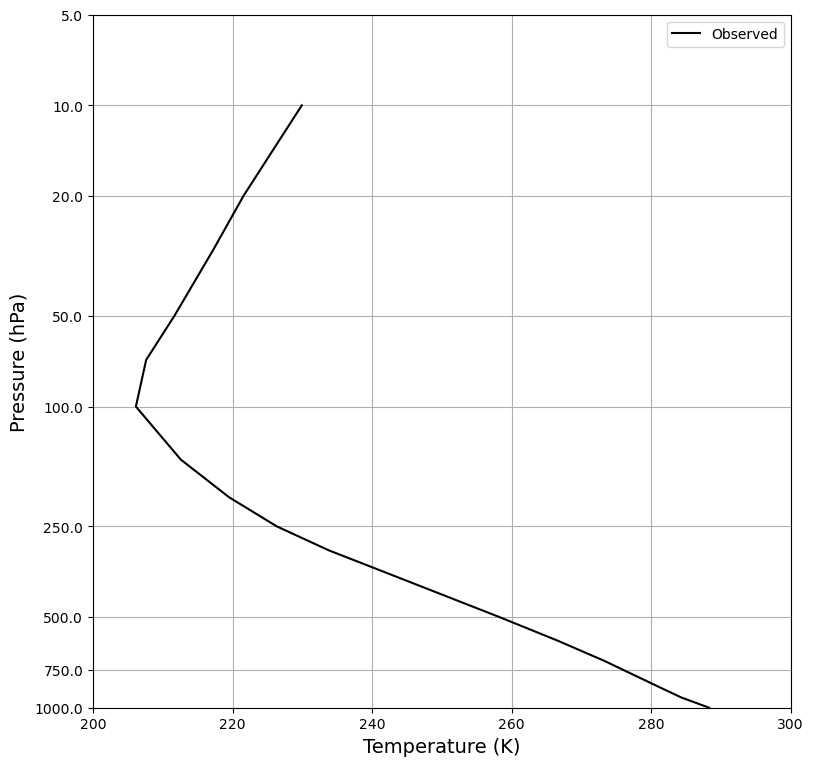

In [26]:
plot_soundings([],[] );

____________
<a id='section4'></a>

## 4. A 30-layer model using the observed temperatures
____________



In [27]:
#  initialize a grey radiation model with 30 levels
col = climlab.GreyRadiationModel()
print(col)

climlab Process of type <class 'climlab.model.column.GreyRadiationModel'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (30,) 
The subprocess tree: 
Untitled: <class 'climlab.model.column.GreyRadiationModel'>
   LW: <class 'climlab.radiation.greygas.GreyGas'>
   SW: <class 'climlab.radiation.greygas.GreyGasSW'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>



In [28]:
col.lev

array([ 16.66666667,  50.        ,  83.33333333, 116.66666667,
       150.        , 183.33333333, 216.66666667, 250.        ,
       283.33333333, 316.66666667, 350.        , 383.33333333,
       416.66666667, 450.        , 483.33333333, 516.66666667,
       550.        , 583.33333333, 616.66666667, 650.        ,
       683.33333333, 716.66666667, 750.        , 783.33333333,
       816.66666667, 850.        , 883.33333333, 916.66666667,
       950.        , 983.33333333])

In [29]:
col.lev_bounds

array([   0.        ,   33.33333333,   66.66666667,  100.        ,
        133.33333333,  166.66666667,  200.        ,  233.33333333,
        266.66666667,  300.        ,  333.33333333,  366.66666667,
        400.        ,  433.33333333,  466.66666667,  500.        ,
        533.33333333,  566.66666667,  600.        ,  633.33333333,
        666.66666667,  700.        ,  733.33333333,  766.66666667,
        800.        ,  833.33333333,  866.66666667,  900.        ,
        933.33333333,  966.66666667, 1000.        ])

In [30]:
# interpolate to 30 evenly spaced pressure levels
lev = col.lev
Tinterp = np.interp(lev, np.flipud(Tglobal.level), np.flipud(Tglobal))
Tinterp
#  Need to 'flipud' because the interpolation routine 
#  needs the pressure data to be in increasing order

array([224.34736633, 211.6633606 , 206.96233453, 208.29142253,
       212.58642578, 217.19396973, 221.78252157, 226.3520813 ,
       231.30422974, 236.08017476, 240.67991638, 245.279658  ,
       249.35979716, 252.92033386, 256.48087056, 259.66789246,
       262.48139954, 265.29490662, 267.81303914, 270.03579712,
       272.25855509, 274.21642049, 275.90939331, 277.60236613,
       279.29533895, 280.98831177, 282.48550415, 283.98269653,
       285.6810201 , 287.4463874 ])

In [31]:
# Initialize model with observed temperatures
col.Ts[:] = Tglobal[0]
col.Tatm[:] = Tinterp

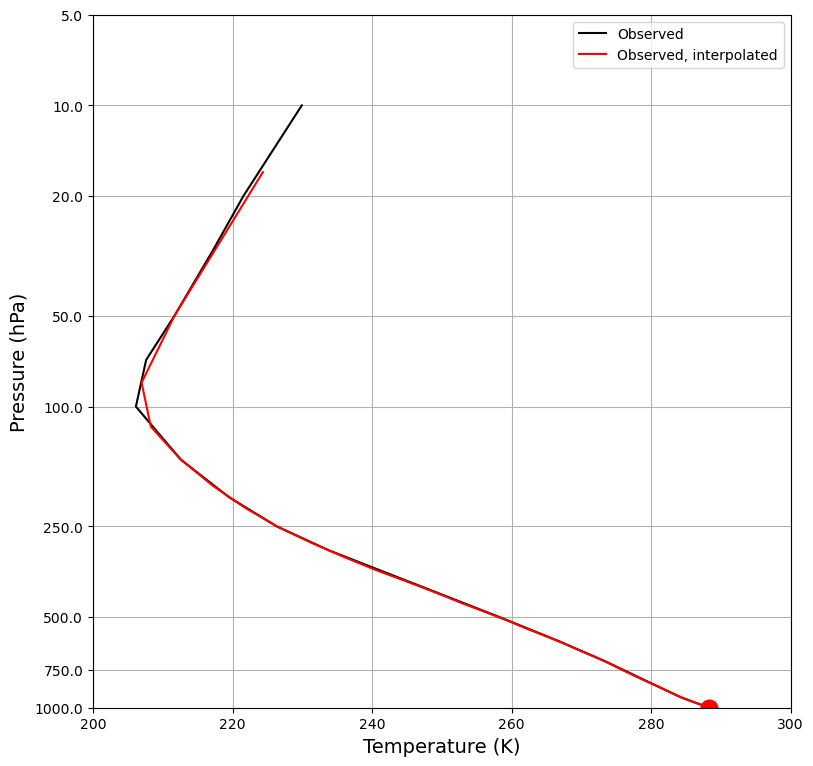

In [32]:
# This should look just like the observations
result_list = [col.state]
name_list = ['Observed, interpolated']
plot_soundings(result_list, name_list);

### Tune absorptivity to get observed OLR

In [33]:
col.compute_diagnostics()
col.OLR

array([263.15000104])

In [34]:
# Need to tune absorptivity to get OLR = 238.5
epsarray = np.linspace(0.01, 0.1, 100)
OLRarray = np.zeros_like(epsarray)

Text(0, 0.5, 'OLR')

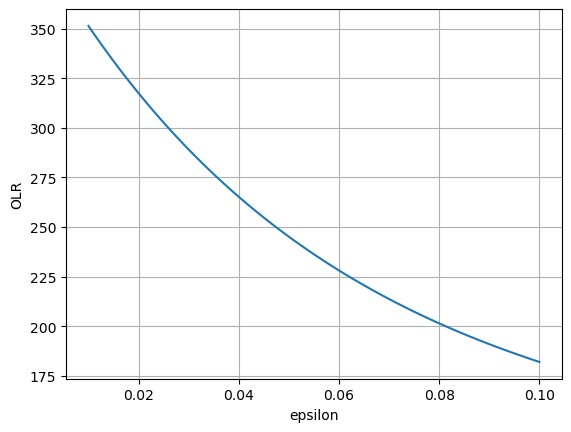

In [35]:
for i in range(epsarray.size):
    col.subprocess['LW'].absorptivity = epsarray[i]
    col.compute_diagnostics()
    OLRarray[i] = col.OLR

plt.plot(epsarray, OLRarray)
plt.grid()
plt.xlabel('epsilon')
plt.ylabel('OLR')

The necessary value seems to lie near 0.055 or so.

We can be more precise with a numerical root-finder.

In [36]:
def OLRanom(eps):
    col.subprocess['LW'].absorptivity = eps
    col.compute_diagnostics()
    return col.OLR - 238.5

In [37]:
# Use numerical root-finding to get the equilibria
from scipy.optimize import brentq
# brentq is a root-finding function
#  Need to give it a function and two end-points
#  It will look for a zero of the function between those end-points
eps = brentq(OLRanom, 0.01, 0.1)
print( eps)

0.05369073166506245


In [38]:
col.subprocess.LW.absorptivity = eps
col.subprocess.LW.absorptivity

Field([0.05369073, 0.05369073, 0.05369073, 0.05369073, 0.05369073,
       0.05369073, 0.05369073, 0.05369073, 0.05369073, 0.05369073,
       0.05369073, 0.05369073, 0.05369073, 0.05369073, 0.05369073,
       0.05369073, 0.05369073, 0.05369073, 0.05369073, 0.05369073,
       0.05369073, 0.05369073, 0.05369073, 0.05369073, 0.05369073,
       0.05369073, 0.05369073, 0.05369073, 0.05369073, 0.05369073])

In [39]:
col.compute_diagnostics()
col.OLR

array([238.5])

____________
<a id='section5'></a>

## 5. Radiative forcing in the 30-layer model
____________

Let's compute radiative forcing for a **2% increase in absorptivity**.

In [40]:
#  clone our model using a built-in climlab function
col2 = climlab.process_like(col)
print(col2)

climlab Process of type <class 'climlab.model.column.GreyRadiationModel'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (30,) 
The subprocess tree: 
Untitled: <class 'climlab.model.column.GreyRadiationModel'>
   LW: <class 'climlab.radiation.greygas.GreyGas'>
   SW: <class 'climlab.radiation.greygas.GreyGasSW'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>



In [41]:
col2.subprocess['LW'].absorptivity *= 1.02
col2.subprocess['LW'].absorptivity

Field([0.05476455, 0.05476455, 0.05476455, 0.05476455, 0.05476455,
       0.05476455, 0.05476455, 0.05476455, 0.05476455, 0.05476455,
       0.05476455, 0.05476455, 0.05476455, 0.05476455, 0.05476455,
       0.05476455, 0.05476455, 0.05476455, 0.05476455, 0.05476455,
       0.05476455, 0.05476455, 0.05476455, 0.05476455, 0.05476455,
       0.05476455, 0.05476455, 0.05476455, 0.05476455, 0.05476455])

In [42]:
#  Radiative forcing by definition is the change in TOA radiative flux,
# HOLDING THE TEMPERATURES FIXED.
col2.Ts - col.Ts

Field([0.])

In [43]:
col2.Tatm - col.Tatm

Field([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [44]:
col2.compute_diagnostics()
col2.OLR

array([236.65384137])

The OLR decreased after we added the extra absorbers, as we expect. Now we can calculate the Radiative Forcing:

In [45]:
RF = -(col2.OLR - col.OLR)
print( 'The radiative forcing is %.2f W/m2.' %RF)

The radiative forcing is 1.85 W/m2.


____________
<a id='section6'></a>

## 6. Radiative equilibrium in the 30-layer model
____________


In [46]:
re = climlab.process_like(col)

In [47]:
#  To get to equilibrium, we just time-step the model forward long enough
re.integrate_years(1.)

Integrating for 365 steps, 365.2422 days, or 1.0 years.


Total elapsed time is 0.9993368783782377 years.


In [48]:
#  Check for energy balance
print( 'The net downward radiative flux at TOA is %.4f W/m2.' %(re.ASR - re.OLR))

The net downward radiative flux at TOA is -0.0015 W/m2.


<AxesSubplot:xlabel='Temperature (K)', ylabel='Pressure (hPa)'>

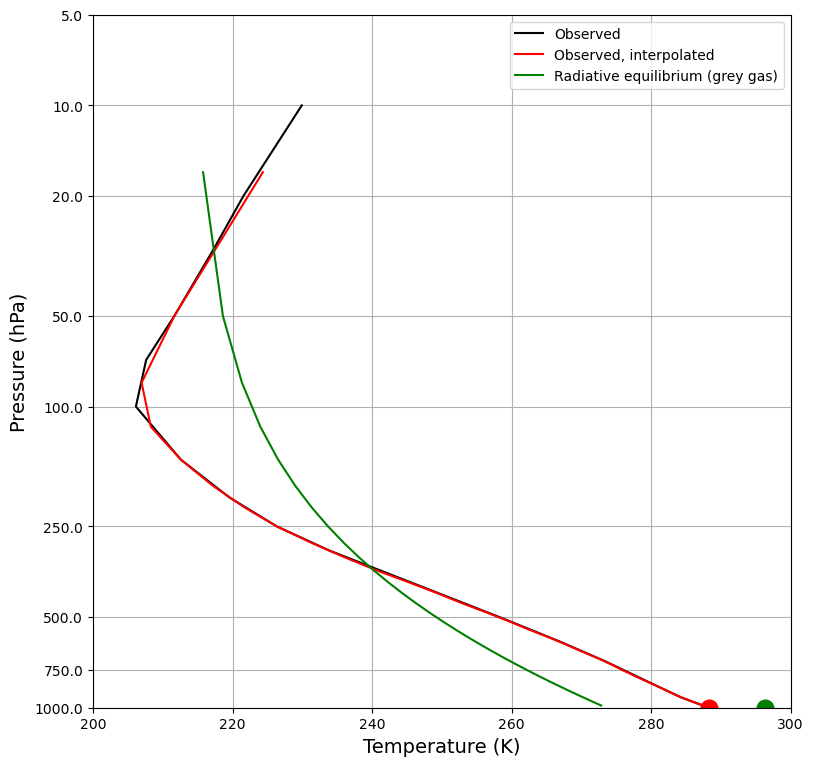

In [49]:
result_list.append(re.state)
name_list.append('Radiative equilibrium (grey gas)')
plot_soundings(result_list, name_list)

Some properties of the **radiative equilibrium** temperature profile:

- The surface is warmer than observed.
- The lower troposphere is colder than observed.
- Very cold air is sitting immediately above the warm surface.
- There is no tropopause, no stratosphere.

____________
<a id='section7'></a>

## 7. Radiative-Convective Equilibrium in the 30-layer model
____________

We recognize that the large drop in temperature just above the surface is unphysical. Parcels of air in direct contact with the ground will be warmed by mechansisms other than radiative transfer.

These warm air parcels will then become buoyant, and will convect upward, mixing their heat content with the environment.

We **parameterize** the statistical effects of this mixing through a **convective adjustment**. 

At each timestep, our model checks for any locations at which the **lapse rate** exceeds some threshold. Unstable layers are removed through an energy-conserving mixing formula.

This process is assumed to be fast relative to radiative heating. In the model, it is instantaneous.

### Add the convective adjustment as an additional subprocess

In [50]:
#  Here is the existing model
print(re)

climlab Process of type <class 'climlab.model.column.GreyRadiationModel'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (30,) 
The subprocess tree: 
Untitled: <class 'climlab.model.column.GreyRadiationModel'>
   LW: <class 'climlab.radiation.greygas.GreyGas'>
   SW: <class 'climlab.radiation.greygas.GreyGasSW'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>



In [51]:
#  First we make a new clone
rce = climlab.process_like(re)
#  Then create a new ConvectiveAdjustment process
conv = climlab.convection.ConvectiveAdjustment(state=rce.state, 
                                               adj_lapse_rate=6.)
#  And add it to our model
rce.add_subprocess('Convective Adjustment', conv)
print( rce)

climlab Process of type <class 'climlab.model.column.GreyRadiationModel'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (30,) 
The subprocess tree: 
Untitled: <class 'climlab.model.column.GreyRadiationModel'>
   LW: <class 'climlab.radiation.greygas.GreyGas'>
   SW: <class 'climlab.radiation.greygas.GreyGasSW'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>
   Convective Adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>



This model is exactly like our previous models, except for one additional subprocess called ``Convective Adjustment``. 

We passed a parameter ``adj_lapse_rate`` (in K / km) that sets the neutrally stable lapse rate -- in this case, 6 K / km.

This number is chosed to very loosely represent the net effect of **moist convection**.

In [52]:
#  Run out to equilibrium
rce.integrate_years(1.)

Integrating for 365 steps, 365.2422 days, or 1.0 years.


Total elapsed time is 1.9986737567564754 years.


In [53]:
#  Check for energy balance
rce.ASR - rce.OLR

Field([0.0007796])

In [54]:
result_list.append(rce.state)
name_list.append('Radiatve-Convective equilibrium (grey gas)')

<AxesSubplot:xlabel='Temperature (K)', ylabel='Pressure (hPa)'>

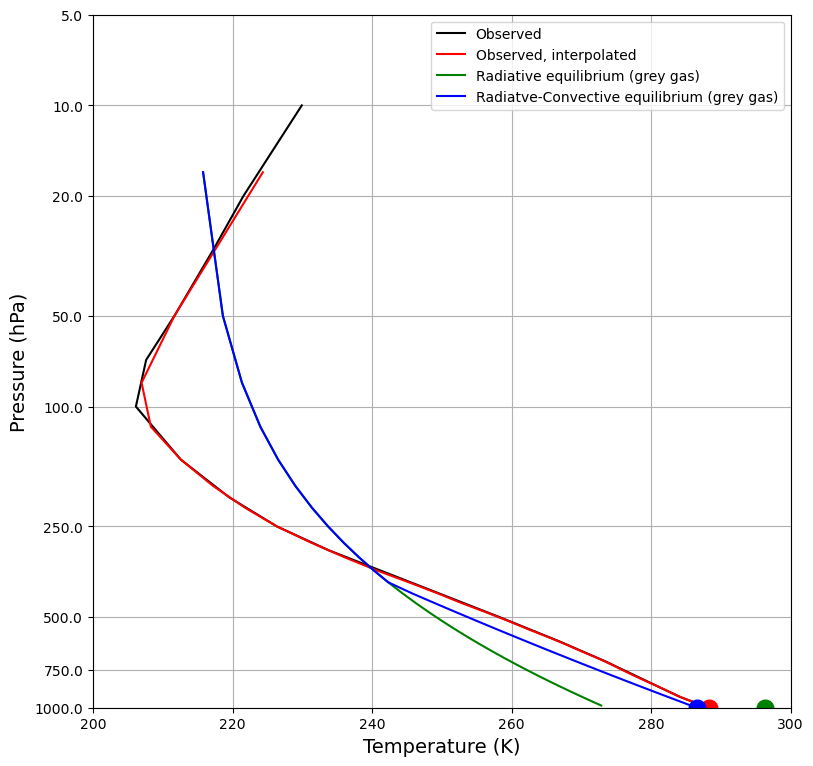

In [55]:
plot_soundings(result_list, name_list)

Introducing convective adjustment into the model cools the surface quite a bit (compared to Radiative Equilibrium, in green here) -- and warms the lower troposphere. It gives us a MUCH better fit to observations.

But of course we still have no stratosphere.

____________
<a id='section8'></a>

## 8. Putting stratospheric ozone in the grey-gas model
____________

Our model has no equivalent of the stratosphere, where temperature increases with height. That's because our model has been completely transparent to shortwave radiation up until now.

We can load the observed ozone climatology from the input files for the CESM model:

In [56]:
datapath = "http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/"
ozone = xr.open_dataset( datapath + "som_input/ozone_1.9x2.5_L26_2000clim_c091112.nc")

In [57]:
print(ozone)

<xarray.Dataset>
Dimensions:  (ilev: 27, lat: 96, lev: 26, lon: 144, slat: 95, slon: 144, time: 12)
Coordinates:
  * ilev     (ilev) float64 2.194 4.895 9.882 18.05 ... 903.3 956.0 985.1 1e+03
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lev      (lev) float64 3.545 7.389 13.97 23.94 ... 867.2 929.6 970.6 992.6
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * slat     (slat) float64 -89.05 -87.16 -85.26 -83.37 ... 85.26 87.16 89.05
  * slon     (slon) float64 -1.25 1.25 3.75 6.25 ... 348.8 351.2 353.8 356.2
  * time     (time) object 2000-01-15 00:00:00 ... 2000-12-15 00:00:00
Data variables:
    P0       float64 ...
    date     (time) int32 ...
    datesec  (time) int32 ...
    gw       (lat) float64 ...
    hyai     (ilev) float64 ...
    hyam     (lev) float64 ...
    hybi     (ilev) float64 ...
    hybm     (lev) float64 ...
    w_stag   (slat) float64 ...
    O3       (time, lev, lat, lon) float32 ...
    PS  

The pressure levels in this dataset are:

In [58]:
print(ozone.lev)

<xarray.DataArray 'lev' (lev: 26)>
array([  3.544638,   7.388814,  13.967214,  23.944625,  37.23029 ,  53.114605,
        70.05915 ,  85.439115, 100.514695, 118.250335, 139.115395, 163.66207 ,
       192.539935, 226.513265, 266.481155, 313.501265, 368.81798 , 433.895225,
       510.455255, 600.5242  , 696.79629 , 787.70206 , 867.16076 , 929.648875,
       970.55483 , 992.5561  ])
Coordinates:
  * lev      (lev) float64 3.545 7.389 13.97 23.94 ... 867.2 929.6 970.6 992.6
Attributes:
    long_name:      hybrid level at midpoints (1000*(A+B))
    units:          level
    positive:       down
    standard_name:  atmosphere_hybrid_sigma_pressure_coordinate
    formula_terms:  a: hyam b: hybm p0: P0 ps: PS


### Take the global average of the ozone climatology, and plot it as a function of pressure (or height)

In [59]:
#  Take global, annual average and convert to Kelvin
weight_ozone = cos(deg2rad(ozone.lat)) / cos(deg2rad(ozone.lat)).mean(dim='lat')
O3_global = (ozone.O3 * weight_ozone).mean(dim=('lat','lon','time'))
print(O3_global)

<xarray.DataArray (lev: 26)>
array([7.82792878e-06, 8.64150529e-06, 7.58940028e-06, 5.24567145e-06,
       3.17761574e-06, 1.82320006e-06, 9.80756960e-07, 6.22870516e-07,
       4.47620550e-07, 3.34481169e-07, 2.62570302e-07, 2.07898125e-07,
       1.57074555e-07, 1.12425545e-07, 8.06004999e-08, 6.27826498e-08,
       5.42990561e-08, 4.99506089e-08, 4.60075681e-08, 4.22977789e-08,
       3.80559071e-08, 3.38768568e-08, 3.12171619e-08, 2.97807119e-08,
       2.87980968e-08, 2.75429934e-08])
Coordinates:
  * lev      (lev) float64 3.545 7.389 13.97 23.94 ... 867.2 929.6 970.6 992.6


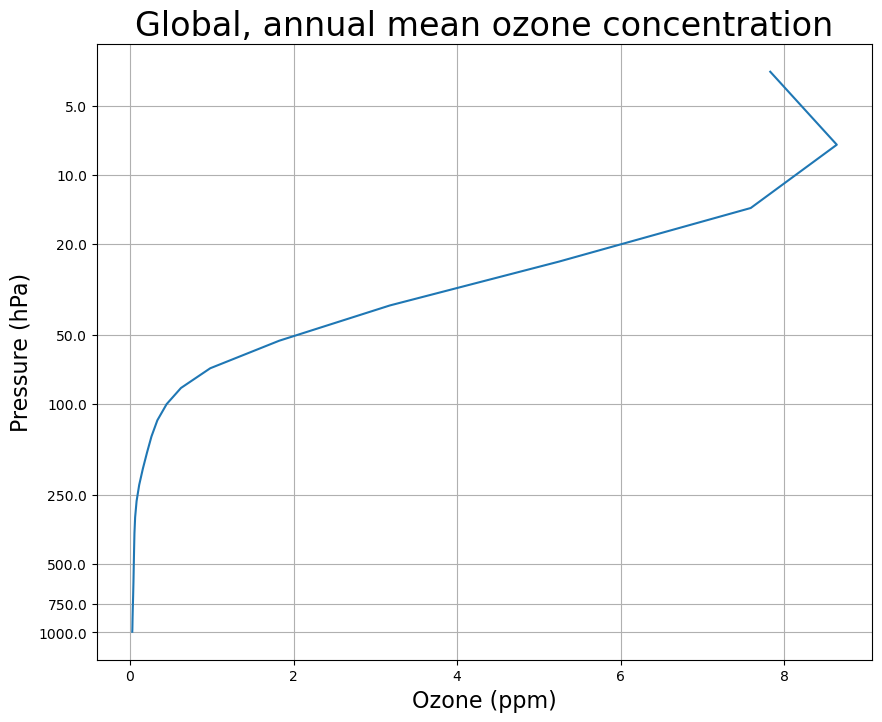

In [60]:
ax = plt.figure(figsize=(10,8)).add_subplot(111)
ax.plot( O3_global * 1.E6, -np.log(ozone.lev/climlab.constants.ps) )
ax.set_xlabel('Ozone (ppm)', fontsize=16)
ax.set_ylabel('Pressure (hPa)', fontsize=16 )
yticks = np.array([1000., 750., 500., 250., 100., 50., 20., 10., 5.])
ax.set_yticks(-np.log(yticks/1000.))
ax.set_yticklabels(yticks)
ax.grid()
ax.set_title('Global, annual mean ozone concentration', fontsize = 24);

This shows that most of the ozone is indeed in the stratosphere, and peaks near the top of the stratosphere.

Now create a new column model object **on the same pressure levels as the ozone data**.  We are also going set an adjusted lapse rate of 6 K / km.

In [61]:
# the RadiativeConvectiveModel is pre-defined in climlab
#  It contains the same components are our previous model
#   But here we are specifying a different set of vertical levels.
oz_col = climlab.RadiativeConvectiveModel(lev = ozone.lev, adj_lapse_rate=6)
print(oz_col)

climlab Process of type <class 'climlab.model.column.RadiativeConvectiveModel'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (26,) 
The subprocess tree: 
Untitled: <class 'climlab.model.column.RadiativeConvectiveModel'>
   LW: <class 'climlab.radiation.greygas.GreyGas'>
   SW: <class 'climlab.radiation.greygas.GreyGasSW'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>



Now we will do something new: let the column absorb some shortwave radiation. We will assume that the shortwave absorptivity is proportional to the ozone concentration we plotted above. 

Now we need to weight the absorptivity by the pressure (mass) of each layer.

In [62]:
# This number is an arbitrary parameter that scales how absorptive we are making the ozone
# in our grey gas model
ozonefactor = 75
dp = oz_col.Tatm.domain.lev.delta
epsSW = O3_global.values * dp * ozonefactor

We want to use the field `epsSW` as the absorptivity for our SW radiation model.

Let's see what the absorptivity is current set to:

In [63]:
print(oz_col.subprocess['SW'].absorptivity)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


It defaults to zero.

Before changing this (putting in the ozone), let's take a look at the shortwave absorption in the column:

In [64]:
oz_col.compute_diagnostics()

In [65]:
oz_col.diagnostics['SW_absorbed_atm']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

Let's now put in the ozone:

In [66]:
oz_col.subprocess['SW'].absorptivity = epsSW
print(oz_col.subprocess['SW'].absorptivity)

[3.20948549e-03 3.37750296e-03 4.71182551e-03 4.57614201e-03
 3.47591203e-03 2.24450924e-03 1.18884331e-03 7.11369788e-04
 5.50761612e-04 4.84170273e-04 4.47141487e-04 4.16507314e-04
 3.70212131e-04 3.11733073e-04 2.62922861e-04 2.40936639e-04
 2.45147939e-04 2.65307555e-04 2.87482272e-04 2.95567946e-04
 2.67120872e-04 2.16427978e-04 1.66169127e-04 1.15468088e-04
 6.79353134e-05 3.81013280e-05]


Let's check how this changes the SW absorption:

In [67]:
oz_col.compute_diagnostics()
oz_col.SW_absorbed_atm

array([1.40571621, 1.47671285, 2.05685574, 1.99236565, 1.50916587,
       0.97239284, 0.51429089, 0.30750441, 0.23797743, 0.20913838,
       0.19309134, 0.17981756, 0.1597929 , 0.13452308, 0.11343944,
       0.10393806, 0.10574109, 0.11442201, 0.12396838, 0.12743553,
       0.11515129, 0.09328389, 0.07161233, 0.04975714, 0.02927232,
       0.01641659])

It is now non-zero, and largest near the top of the column (also top of the array) where the ozone concentration is highest.

Now it's time to run the model out to radiative-convective equilibrium

In [68]:
oz_col.integrate_years(1.)

Integrating for 365 steps, 365.2422 days, or 1.0 years.


Total elapsed time is 0.9993368783782377 years.


In [69]:
print(oz_col.ASR - oz_col.OLR)

[-0.00396053]


And let's now see what we got!

In [70]:
result_list.append(oz_col.state)
name_list.append('Radiative-Convective equilibrium with O3')

<AxesSubplot:xlabel='Temperature (K)', ylabel='Pressure (hPa)'>

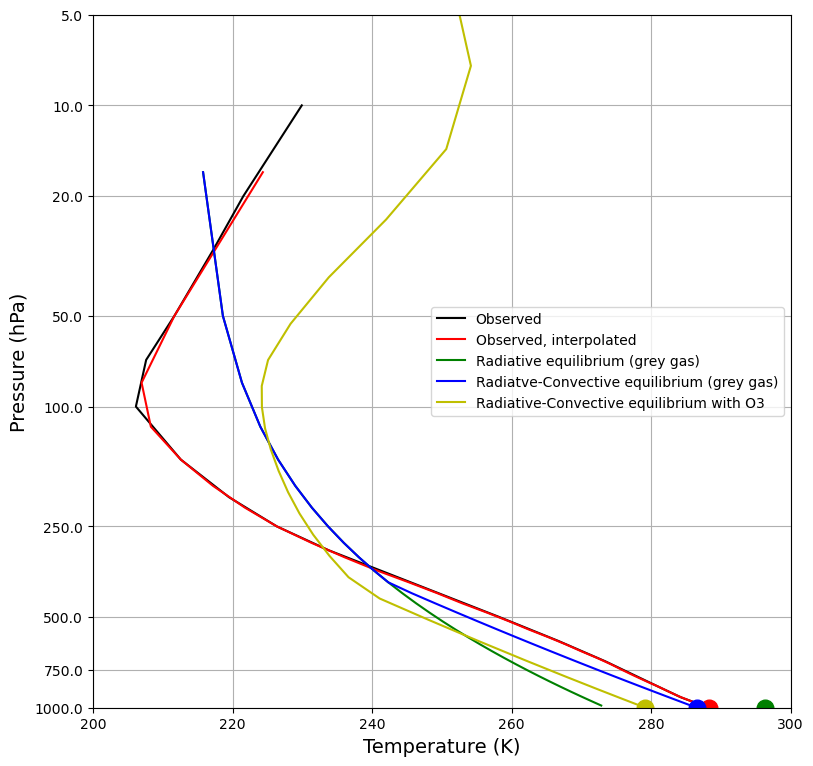

In [71]:
#  Make a plot to compare observations, Radiative Equilibrium, Radiative-Convective Equilibrium, and RCE with ozone!
plot_soundings(result_list, name_list)

And we finally have something that looks looks like the tropopause, with temperature increasing above at approximately the correct rate. 

There are still plenty of discrepancies between this model solution and the observations, including:

- Tropopause temperature is too warm, by about 15 degrees.
- Surface temperature is too cold

There are a number of parameters we might adjust if we wanted to improve the fit, including:

- Longwave absorptivity
- Surface albedo

Feel free to experiment! (That's what models are for, after all).

### The take home message

The dominant effect of stratospheric ozone is to vastly increase the radiative equilibrium temperature in the ozone layer. The temperature needs to be higher so that the longwave emission can balance the shortwave absorption.

Without ozone to absorb incoming solar radiation, the **temperature does not increase with height**.

This simple grey-gas model illustrates this principle very clearly.

____________

## Credits

This notebook is part of [The Climate Laboratory](https://brian-rose.github.io/ClimateLaboratoryBook), an open-source textbook developed and maintained by [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany.

It is licensed for free and open consumption under the
[Creative Commons Attribution 4.0 International (CC BY 4.0)](https://creativecommons.org/licenses/by/4.0/) license.

Development of these notes and the [climlab software](https://github.com/brian-rose/climlab) is partially supported by the National Science Foundation under award AGS-1455071 to Brian Rose. Any opinions, findings, conclusions or recommendations expressed here are mine and do not necessarily reflect the views of the National Science Foundation.
____________